In [61]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_probability as tfp

In [62]:
tf.get_logger().setLevel('ERROR')

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
train_images = np.array(train_images[[i for (i, label) in enumerate(train_labels) if label < 2]])
train_labels = np.array([label for label in train_labels if label < 2])
test_images = np.array(test_images[[i for (i, label) in enumerate(test_labels) if label < 2]])
test_labels = np.array([label for label in test_labels if label < 2])

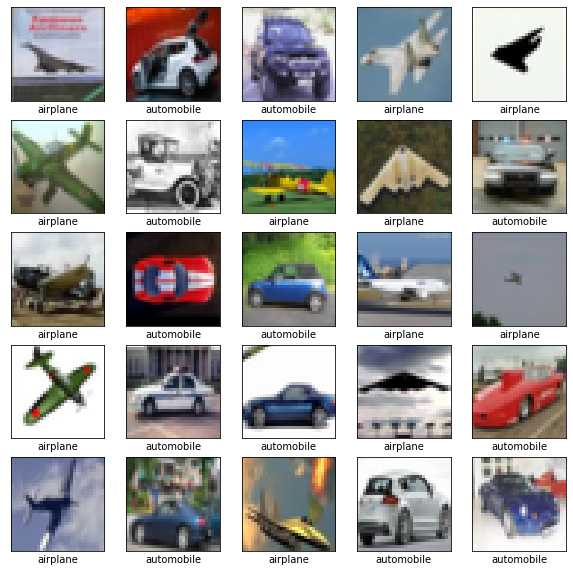

In [41]:
class_names = ['airplane', 'automobile']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[test_labels[i][0]])
plt.show()

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
Total params: 56,320
Trainable params: 56,320
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.add(tfp.layers.DistributionLambda(
    lambda t: tfp.distributions.Bernoulli(logits=t)))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [15]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
#               loss='sparse_categorical_crossentropy',
              loss=lambda y, p_y: -p_y.log_prob(y),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 10000 samples, validate on 2000 samples
Epoch 1/10
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.4236 - accuracy: 0.7206 - val_loss: 0.3129 - val_accuracy: 0.7985
Epoch 2/10
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.2654 - accuracy: 0.8385 - val_loss: 0.2250 - val_accuracy: 0.8650
Epoch 3/10
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.1977 - accuracy: 0.8817 - val_loss: 0.1976 - val_accuracy: 0.8770
Epoch 4/10
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.1610 - accuracy: 0.9107 - val_loss: 0.1526 - val_accuracy: 0.9200
Epoch 5/10
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.1328 - accuracy: 0.9196 - val_loss: 0.1838 - val_accuracy: 0.9045
Epoch 6/10
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.1113 - accuracy: 0.9348 - val_loss: 0.1417 - val_accuracy: 0.9195
Epoch 7/10
10000/10000 [==============================] -

2000/1 - 1s - loss: 0.1561 - accuracy: 0.9450


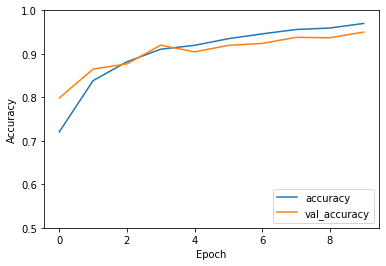

In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [17]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

2000/1 - 1s - loss: 0.1561 - accuracy: 0.9480


In [21]:
preds = [model.predict(test_images[3:4]) for _ in range(10)]

In [20]:
model.predict(test_images[1:2])

array([[1]], dtype=int32)

In [23]:
model.evaluate(test_images,  test_labels, verbose=2)

2000/1 - 0s - loss: 0.1843 - accuracy: 0.9585


[0.18715918546915053, 0.9585]

In [31]:
preds = [abs(pd.DataFrame(model(test_images[i:i+1]).sample(10000).numpy().squeeze()).mean() - 0.5) for i in range(len(test_images))]

In [37]:
np.array(preds).argmin()

607

In [46]:
model(test_images[608:609]).sample(100)

<tf.Tensor: id=477610, shape=(100, 1, 1), dtype=int32, numpy=
array([[[0]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[1]],

       [[1]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[0]],

       [[0]],

       [[0]],

       [

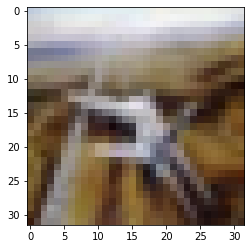

In [47]:
plt.imshow(test_images[608], cmap=plt.cm.binary)

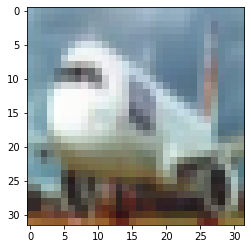

In [53]:
plt.imshow(test_images[1022], cmap=plt.cm.binary)

In [52]:
model(test_images[1022:1023]).sample(100).numpy().squeeze().mean()

0.97

In [54]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

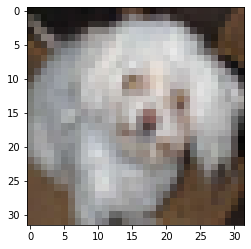

In [58]:
plt.imshow(test_images[1000], cmap=plt.cm.binary)

In [60]:
model(test_images[1000:1001]).sample(100).numpy().squeeze()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [131]:
test_labels[4]

array([0], dtype=uint8)

In [242]:
import pandas as pd
arr = model(test_images).sample(100).numpy().squeeze()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [243]:
arr.shape

(100, 2000, 2)

In [244]:
arr

array([[[0, 0],
        [1, 1],
        [1, 1],
        ...,
        [0, 0],
        [0, 0],
        [1, 1]],

       [[0, 0],
        [1, 1],
        [1, 1],
        ...,
        [0, 0],
        [0, 0],
        [1, 1]],

       [[0, 0],
        [1, 1],
        [1, 1],
        ...,
        [0, 0],
        [0, 0],
        [1, 1]],

       ...,

       [[0, 0],
        [1, 1],
        [1, 1],
        ...,
        [0, 0],
        [0, 0],
        [1, 1]],

       [[0, 0],
        [1, 1],
        [1, 1],
        ...,
        [0, 0],
        [0, 0],
        [1, 1]],

       [[0, 0],
        [1, 1],
        [1, 1],
        ...,
        [0, 0],
        [0, 0],
        [1, 1]]], dtype=int32)

In [250]:
pd.DataFrame(arr.reshape(2000, 100, 2)[0]).mean()

0    0.45
1    0.47
dtype: float64

In [165]:
test_labels[0]

array([0], dtype=uint8)